In [62]:
try: 
    import cv2
    import torch
    import torchvision
    import sklearn.svm
    import mediapipe as mp
      
except:
    %pip install opencv-python-headless==4.9.0.80
    %pip install torch
    %pip install torchvision
    %pip install torchsummary 
    %pip install sklearn
    %pip install mediapipe

# torch
import torch
from torch.utils.data import Dataset
from torch import cuda
from torchvision import transforms, datasets, models
import torch.optim as optim
import torch.nn as nn
from torch.optim import lr_scheduler
from torchsummary import summary

# scikit learn
from skimage.feature import hog
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import RandomizedSearchCV

# mediapipe
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# standard libraries
import random
import time
import copy
import pickle
import re
import shutil
from pathlib import Path
from collections import Counter
from timeit import default_timer as timer

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

np.set_printoptions(threshold=np.inf)
print('import successful')

import successful


In [59]:
# install protobuf for mediapipe
%pip uninstall protobuf -y
#%pip install protobuf==4.25.3

Found existing installation: protobuf 4.25.3
Uninstalling protobuf-4.25.3:
  Successfully uninstalled protobuf-4.25.3
Note: you may need to restart the kernel to use updated packages.


In [61]:
%pip install protobuf==4.25.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 6.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.27.2
    Uninstalling protobuf-5.27.2:
      Successfully uninstalled protobuf-5.27.2
Note: you may need to restart the kernel to use updated packages.


### Remove Jupyter Checkpoints

In [3]:
# remove checkpoints
checkpoints = list(Path('/home/jovyan/work').rglob('.ipynb_checkpoints'))

for file in checkpoints:
    if file.is_dir():        
        for sub_file in file.iterdir():
            if sub_file.is_file():
                sub_file.unlink()
            elif sub_file.is_dir():
                sub_file.rmdir()
    file.rmdir()

print('done')

done


### Init Data Path & Parameters

In [63]:
# Dataset Parameters
BASE_PATH = Path('/home/jovyan/work/data/out')

EMOREACT = 'EmoReact'
FER = 'FER-2013'
KDEF = 'KDEF-AKDEF'
NIMH = 'NIMH-CHEFS'
INTERNAL = Path('/home/jovyan/work/output/extracted_faces')

DATASET = EMOREACT

DATA_PATH = Path('/home/jovyan/work/data/out/') / DATASET
DATA_PATH = INTERNAL

# Dataset-specific paths
LABELS = [f.name for f in DATA_PATH.iterdir() if f.is_dir()]
IMAGE_PATHS = list(DATA_PATH.rglob('*.jpg'))

# Constants for splitting dataset
TRAIN = 'train'
TEST = 'test'
VAL = 'val'

# Model parameters
MODEL_PATH = Path('/home/jovyan/work/models')
BATCH_SIZE = 16
SUBSET_RATIO = 0.1
SUBSET = False

# Constants for feature extraction
FEATURES = 'feature-extraction'
TRANSFER = 'transfer-learning'
FINETUNE = 'fine-tuning'

# Cuda parameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
torch.cuda.get_device_name(0)

# feature extaraction
orientations = 7
pixels_per_cell = 8
cells_per_block = 4

hog_params = { 
    'orientations': orientations,
    'pixels_per_cell': pixels_per_cell,
    'cells_per_block': cells_per_block
}

### Dataset Class

In [64]:
class Dataset(Dataset):
    def __init__(self, data_path, phase, img_size=64, transform=None, model_path_mesh='/home/jovyan/work/models/face_landmarker.task', **kwargs):
        self.data_path = Path(data_path) / phase
        self.img_size = img_size
        self.transform = transform[phase]
        self.phase = phase

        self.classes = self._get_classes()
        self.image_paths = self._get_image_paths()
        self.num_classes = len(self.classes)

        self.class_to_int = {class_name: idx for idx, class_name in enumerate(self.classes)}
        self.int_to_class = {idx: class_name for class_name, idx in self.class_to_int.items()}

        # feature extraction
        self.hog_args = kwargs
        self.labels = []
        self.data = []
        self.df = pd.DataFrame()

        # mediapipe
        self.model_path_mesh = model_path_mesh
        self.base_options_mesh = python.BaseOptions(model_asset_path=model_path_mesh)
        self.options_mesh = vision.FaceLandmarkerOptions(base_options=self.base_options_mesh, output_face_blendshapes=True, output_facial_transformation_matrixes=True, num_faces=1)
        self.detector_mesh = vision.FaceLandmarker.create_from_options(self.options_mesh)

    def _get_classes(self):
        return [f.name for f in self.data_path.iterdir() if f.is_dir()]

    def _get_image_paths(self):
        paths = list(self.data_path.rglob('*.jpg'))
        random.shuffle(paths)
        return paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx])
        img_path = self.image_paths[idx]
        if self.transform:
            img = self.transform(img)
        label = Path(img_path).parent.name
        label = self.class_to_int[label]  # convert label to integer
        return img, label

    def get_cv2_img(self, idx):
        img_path = self.image_paths[idx]
        img = cv2.imread(str(img_path))
        img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
        return img

    def idx_to_class(self, idx_list):
        return [self.int_to_class[idx] for idx in idx_list]

    def class_to_idx(self, class_list):
        return [self.class_to_int[class_name] for class_name in class_list]

    def show_image(self, idx):
        img_cv2 = self.get_cv2_img(idx)
        plt.imshow(img_cv2, cmap='gray')
        plt.show()
    
    def extract_features(self, feature):
        print(f"[INFO] Extracting {feature} vectors ...")
        labels = []
        data = []
        
        for idx in tqdm(range(len(self))):
            img, label = self[idx]
            img_cv2 = self.get_cv2_img(idx)

           # print(img_cv2.shape)

            if feature == 'landmarks':
                rgb_frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_cv2)
                detection_result = self.detector_mesh.detect(rgb_frame)
                if detection_result.face_landmarks:
                    array = np.array([[lm.x, lm.y, lm.z] for lm in detection_result.face_landmarks[0]]).flatten()
                    labels.append(label)
                    data.append(array)

            elif feature == 'pixel':
                labels.append(label)
                img_array = np.array(img).flatten()
                data.append(img_array)

            elif feature == 'hog':
                orientations = self.hog_args['hog_params'].get('orientations', None)
                pixels_per_cell = self.hog_args['hog_params'].get('pixels_per_cell', None)
                cells_per_block = self.hog_args['hog_params'].get('cells_per_block', None)
                
                if orientations is None or pixels_per_cell is None or cells_per_block is None:
                    raise ValueError("orientations, pixels_per_cell and cells_per_block are required for hog feature extraction")

                fd1 = hog(
                    img_cv2, orientations=orientations, 
                    pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                    cells_per_block=(cells_per_block, cells_per_block),
                    block_norm='L2-Hys',
                    transform_sqrt=False, 
                    feature_vector=True,
                    channel_axis=-1
                    )

                labels.append(label)
                data.append(fd1)
                #if len(fd1) != 94192:
                #    print(idx)
                #    return
                #print(len(fd1))

            elif feature == 'blendshapes':
                rgb_frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_cv2)
                detection_result = self.detector_mesh.detect(rgb_frame)
                if detection_result.face_blendshapes:
                    array = np.array([[bs.index, bs.score] for bs in detection_result.face_blendshapes[0]]).flatten()
                    labels.append(label)
                    data.append(array)
            
            else:
                raise ValueError(f"[Value Error] Unsupported feature type: {feature}! Should be one of: [blendshapes, pixel, landmark, hog]")

        data = np.array(data)
        labels = np.array(labels)
        return data, labels

In [65]:
data_transforms = {
    TRAIN: transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        #transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        #transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

In [66]:
datasets = { x: Dataset(DATA_PATH, phase=x, img_size=256, transform=data_transforms, hog_params=hog_params) for x in [TRAIN, VAL, TEST] }
dataloaders = { x: torch.utils.data.DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4) for x in [TRAIN, VAL, TEST] }
dataset_sizes = { x : len(datasets[x]) for x in [TRAIN, VAL, TEST] }
n_classes = datasets[TRAIN].num_classes

I0000 00:00:1721137942.802379    4681 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1721137942.804440    4681 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
W0000 00:00:1721137942.812156   13530 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1721137942.821344   13546 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1721137942.924880    4681 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1721137942.926177    4681 face_landmarker_graph.cc:174] Sets F

In [67]:
print(datasets[TRAIN][0][0].shape)

img_cv2 = datasets[TRAIN].get_cv2_img(101)

#datasets[TRAIN].show_image(101)

print(img_cv2.shape)

fd1 = hog(
    img_cv2, orientations=orientations, 
    pixels_per_cell=(pixels_per_cell, pixels_per_cell),
    cells_per_block=(cells_per_block, cells_per_block),
    block_norm='L2-Hys',
    transform_sqrt=False, 
    feature_vector=True,
    channel_axis=-1
)

fd1.shape

# 16128

torch.Size([3, 224, 224])
(256, 256, 3)


(94192,)

### Init VGG16 for Feature Extraction

In [68]:
# init the VGG model
vgg16 = models.vgg16(weights='IMAGENET1K_V1')
vgg16 = vgg16.to(DEVICE)

# freeze parameters for feature extraction
for param in vgg16.features.parameters():
    param.require_grad = False

# remove classifer to output features
vgg16.classifier = torch.nn.Identity()
vgg16.classifier = vgg16.classifier.to(DEVICE)

### Extract features

In [69]:
# this is the feature extraction method
def extract_vgg_features(loader, conv_base):
    conv_base.eval()
    features = []
    labels = []

    with torch.no_grad():
        for (images, targets) in loader:
            # move data to cuda
            images = images.to(DEVICE)
            targets = torch.as_tensor(targets).to(DEVICE)
            
            # Extract features using conv_base
            features_batch = conv_base(images)
            features.append(features_batch.cpu().numpy())
            labels.append(targets.cpu().numpy())

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

In [77]:
FEATURE = 'hog'
VGG = False

if VGG:
    FEATURE = 'VGG'
    since = time.time()
    # extract features
    train_features, train_labels = extract_vgg_features(loader=dataloaders[TRAIN], conv_base=vgg16)
    test_features, test_labels = extract_vgg_features(loader=dataloaders[TEST], conv_base=vgg16)
    val_features, val_labels = extract_vgg_features(loader=dataloaders[VAL], conv_base=vgg16)
    elapsed_time = time.time() - since
    print(f"Feature Extraction completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")
    # combine into one dataset
    vgg_features = np.concatenate((train_features, test_features, val_features))
    vgg_labels = np.concatenate((train_labels, test_labels, val_labels))
    
    print(vgg_features.shape, vgg_labels.shape)
    x_train, x_test, y_train, y_test = train_test_split(vgg_features, vgg_labels, test_size=0.2, shuffle=True, stratify=vgg_labels, random_state=42)

else:
    # extract features
    since = time.time()
    
    manual_train_features, manual_train_labels = datasets[TRAIN].extract_features(feature=FEATURE)
    manual_test_features, manual_test_labels = datasets[TEST].extract_features(feature=FEATURE)
    manual_val_features, manual_val_labels = datasets[VAL].extract_features(feature=FEATURE)
    manual_features = np.concatenate((manual_train_features, manual_test_features, manual_val_features))
    manual_labels = np.concatenate((manual_train_labels, manual_test_labels, manual_val_labels))
    
    elapsed_time = time.time() - since
    print(f"Feature Extraction completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")
    
    print(manual_features.shape, manual_labels.shape)

    x_train, x_test, y_train, y_test = train_test_split(manual_features, manual_labels, test_size=0.2, shuffle=True, stratify=manual_labels, random_state=42)

# create train and test sets 
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

[INFO] Extracting hog vectors ...


100%|██████████| 14348/14348 [10:42<00:00, 22.34it/s]


[INFO] Extracting hog vectors ...


100%|██████████| 4784/4784 [03:29<00:00, 22.87it/s]


[INFO] Extracting hog vectors ...


100%|██████████| 4782/4782 [03:27<00:00, 23.03it/s]


Feature Extraction completed in 20m 34s
(23914, 94192) (23914,)
(19131, 94192) (4783, 94192) (19131,) (4783,)


#### Create Subsamples of Dataset

In [80]:
def stratified_subset(features, labels, ratio):
    num_samples = len(features)
    new_size = int(num_samples * ratio)
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=new_size, random_state=0)
    for train_index, subset_index in sss.split(features, labels):
        subset_features = features[subset_index]
        subset_labels = labels[subset_index]

    print(subset_features.shape, subset_labels.shape)
    return subset_features, subset_labels


def show_distribution(labels, dataset_name, dataset_ratio):
    unique_values, counts = np.unique(labels, return_counts=True)
    
    plt.figure(figsize=(5, 3))
    bars = plt.bar(unique_values, counts, color='skyblue')
    
    for bar, count in zip(bars, counts):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, count, ha='center', va='bottom')
    
    plt.xlabel('Unique Values')
    plt.ylabel('Counts')
    plt.title(f'Distribution of Unique Values {dataset_name}')
    plt.xticks(unique_values)

    Path('/home/jovyan/work/distributions').mkdir(parents=True, exist_ok=True)
    save_path = f'/home/jovyan/work/distributions/distribution_{dataset_name}_{dataset_ratio}.jpg'

    plt.savefig(save_path)
    plt.show()

(1195, 94192) (1195,)


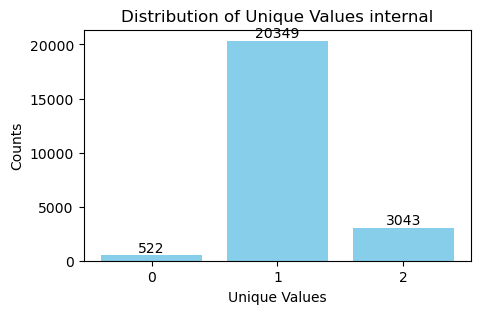

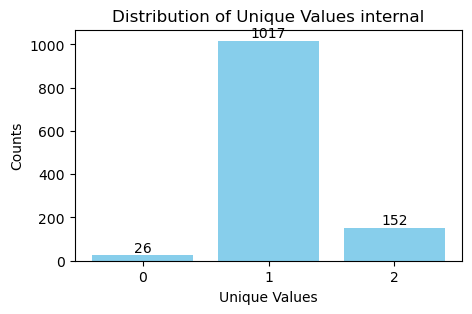

In [81]:
if VGG:
    subset_features, subset_labels = stratified_subset(vgg_features, vgg_labels, 0.05)
else:
    subset_features, subset_labels = stratified_subset(manual_features, manual_labels, 0.05)

x_train, x_test, y_train, y_test = train_test_split(subset_features, subset_labels, test_size=0.2, shuffle=True, stratify=subset_labels, random_state=42)

show_distribution(manual_labels, 'internal', '1.0')
show_distribution(subset_labels, 'internal', '0.1')

In [82]:
def print_score(clf, x_train, y_train, x_test, y_test, mode, train=True):
    if train:
        y_prediction = clf.predict(x_train)
        clf_report = classification_report(y_train, y_prediction)
        train_result = (
            "Train Result:\n"
            "================================================\n"
            f"Accuracy Score: {accuracy_score(y_train, y_prediction) * 100:.2f}%\n"
            "_______________________________________________\n"
            f"CLASSIFICATION REPORT:\n{clf_report}\n"
            "_______________________________________________\n"
            f"Confusion Matrix: \n {confusion_matrix(y_train, y_prediction)}\n\n"
        )
        Path('/home/jovyan/work/reports').mkdir(parents=True, exist_ok=True)
        (Path(f'/home/jovyan/work/reports/training_results_{mode}.txt')).write_text(train_result)

        print(train_result)
        
    elif train==False:
        y_prediction = clf.predict(x_test)
        clf_report = classification_report(y_test, y_prediction)
        test_result = (
            "Test Result:\n"
            "================================================\n"
            f"Accuracy Score: {accuracy_score(y_test, y_prediction) * 100:.2f}%\n"
            "_______________________________________________\n"
            f"CLASSIFICATION REPORT:\n{clf_report}\n"
            "_______________________________________________\n"
            f"Confusion Matrix: \n {confusion_matrix(y_test, y_prediction)}\n\n"
        )
        Path('/home/jovyan/work/reports').mkdir(parents=True, exist_ok=True)
        (Path(f'/home/jovyan/work/reports/test_results_{mode}.txt')).write_text(test_result)

        print(test_result)

#### SVM Init

#### Tune Hyperparameters

In [ ]:
"""
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'poly'],
    'degree': [2, 3]
}
"""

param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['poly'],
    'degree': [2, 3, 4]
}

"""
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3, cv=5)
grid.fit(x_train, y_train)
print("Best Parameters:", grid.best_params_)
best_model = grid.best_estimator_
y_pred = best_model.predict(x_test)
"""

halving_random_search = HalvingRandomSearchCV(SVC(), param_grid, n_candidates='exhaust', refit=True, verbose=3, cv=5, factor=2, random_state=42)
halving_random_search.fit(x_train, y_train)
print("Best Parameters:", halving_random_search.best_params_)
best_model = halving_random_search.best_estimator_
y_pred = best_model.predict(x_test)

"""
random_search = RandomizedSearchCV(SVC(), param_grid, n_iter=10, refit=True, verbose=3, cv=5, random_state=42)
random_search.fit(x_train, y_train)
print("Best Parameters:", random_search.best_params_)
best_model = random_search.best_estimator_
y_pred = best_model.predict(x_test)
"""

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 30
max_resources_: 956
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 31
n_resources: 30
Fitting 5 folds for each of 31 candidates, totalling 155 fits
[CV 1/5] END C=0.1, degree=2, gamma=0.0001, kernel=poly;, score=(train=0.913, test=1.000) total time=   0.7s
[CV 2/5] END C=0.1, degree=2, gamma=0.0001, kernel=poly;, score=(train=0.875, test=0.800) total time=   0.3s
[CV 3/5] END C=0.1, degree=2, gamma=0.0001, kernel=poly;, score=(train=0.917, test=0.800) total time=   0.0s
[CV 4/5] END C=0.1, degree=2, gamma=0.0001, kernel=poly;, score=(train=0.875, test=1.000) total time=   0.0s
[CV 5/5] END C=0.1, degree=2, gamma=0.0001, kernel=poly;, score=(train=0.875, test=0.800) total time=   0.0s
[CV 1/5] END C=1000, degree=2, gamma=0.001, kernel=poly;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 2/5] END C=1000, degree=2, gamma=0.001, kernel=poly;, score=(train=1.000, test=0.80

#### Evaluate

In [76]:
print(f"Results for DATASET: {DATASET}, FEATURE: {FEATURE}")
print("Best Parameters:", halving_random_search.best_params_)
print_score(best_model, x_train, y_train, x_test, y_test, mode='SVM_NIMH-CHEFS', train=False)

kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(best_model, manual_features, manual_labels, scoring='accuracy', cv=kf, n_jobs=2)
print(f"10-Fold CV: {scores.mean():.2f} accuracy with a standard deviation of {scores.std():.2f}")

pkl_name = f'{DATASET}_SVM_{FEATURE}_{halving_random_search.best_params_}.pkl'
pkl_path = str(MODEL_PATH / 'PICKLE' / pkl_name)
#with open(pkl_path, 'wb') as f:
#    pickle.dump(best_model, f)

Results for DATASET: EmoReact, FEATURE: blendshapes
Best Parameters: {'kernel': 'poly', 'gamma': 0.0001, 'degree': 2, 'C': 1000}
Test Result:
Accuracy Score: 85.61%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.86      1.00      0.92       119
           2       0.00      0.00      0.00        17

    accuracy                           0.86       139
   macro avg       0.29      0.33      0.31       139
weighted avg       0.73      0.86      0.79       139

_______________________________________________
Confusion Matrix: 
 [[  0   3   0]
 [  0 119   0]
 [  0  17   0]]




/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


10-Fold CV: 0.87 accuracy with a standard deviation of 0.01


#### Export to ONNX

In [30]:
%pip show protobuf

Name: protobuf
Version: 3.20.2
Summary: Protocol Buffers
Home-page: https://developers.google.com/protocol-buffers/
Author: 
Author-email: 
License: BSD-3-Clause
Location: /opt/conda/lib/python3.11/site-packages
Requires: 
Required-by: mediapipe, onnx, onnxconverter-common, tensorboard, tensorflow
Note: you may need to restart the kernel to use updated packages.


In [18]:
#%pip s protobuf==4.25.3
%pip install onnx skl2onnx

import onnx
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 11.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.4/298.4 kB 8.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.14 requires protobuf<5,>=4.25.3, but you have protobuf 3.20.2 which is incompatible.
tensorflow 2.16.1 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [24]:
initial_type = [('float_input', FloatTensorType([None, x_train.shape[1]]))]
onnx_model = convert_sklearn(best_model, initial_types=initial_type)

onnx_name = 'NIMH-CHEFS_SVM_MODE-blendshapes_KERNEL-poly_DEGREE-2_GAMMA-0.0001_C-100.onnx'
onnx_path = str(MODEL_PATH / 'ONNX' / onnx_model)

with open(onnx_path, "wb") as f:
    f.write(onnx_model.SerializeToString())

In [21]:
pkl_name = 'NIMH-CHEFS_SVM_MODE-blendshapes_KERNEL-poly_DEGREE-1_GAMMA-1_C-1.pkl'

pkl_path = str(MODEL_PATH / 'PICKLE' / pkl_name)

with open(pkl_path, 'wb') as f:
    pickle.dump(best_model, f)